##### Preamble/Imports

In [1]:
import matplotlib
matplotlib.use( "agg" )
%pylab inline

import plt_fmt

from numba import jit

# from fig_annotate import *


from diffusion_integrator_funcs import *
# from frac_brown import *

Populating the interactive namespace from numpy and matplotlib


# Three-dimensional radial equation

In [5]:
# @jit
def jacob(timepoint, yvals, settings_and_params):
    """
    Operator form of a system of coupled differential equations in one variable
    """
    
    settings, params = settings_and_params
    
    allspace = settings['space']
    dx = allspace[2]-allspace[1]
    
    WELL_DIAM = params['WELL_DIAM']
    POT_DIAM = params['POT_DIAM']
    KAPPA = params['KAPPA']
    DCOEFF = params['DCOEFF']
    ALPHA = params['ALPHA']
    
    DCOEFF = ALPHA*(timepoint**(ALPHA-1))*DCOEFF
    
    # remove this and change allspace
    a = POT_DIAM

    L = len(space)
    
    # second derivative step
    lap = lap2d(L)/dx**2
    jac = lap
    
    
    # first derivative steps
    drv = grad1D(L)/dx
    jac += (4*drv/allspace) - (3/(4*a**2))*allspace*drv
    
    
    # other steps
    iden = identity(L)
    jac += (1/(8*a**4))*(allspace**2)*iden
    jac += -(1/a**2)*iden
    # assume \ell = 0
    jac += (2/(allspace**2))*iden
    
    
    # now multiply by diffusion coefficient and all that
    jac = -DCOEFF*jac
    
    # now implement reaction step
    drain_window = double(allspace < WELL_DIAM)
    
    allinds = linspace(0,len(allspace),len(allspace))
    drain_window = smoothstep(allinds,center = sum(drain_window),sharpness=3)

    jac += -KAPPA*drain_window*iden
    
    
#     # now implement boundary conditions
#     jac[0,:] = jac[1,:]
#     jac[-1,:] = jac[-2,:]
    
    return jac


def nxt_step(yvals, timepoint, dt, settings, params):
    """
    Return a space-discretized approximation of the differential equation
    at the given timepoint. Our equation happens to be linear, and so the next
    step is given by a simple dot product with the relevant operator
    """
    jac = jacob(timepoint, yvals, [settings, params])
    nxt_vals = jac.dot(yvals)
    return nxt_vals

# def rk4_mesh(yinit, ynxt, settings, params):
#     """
#     ynxt : function
#         The function that computes the next step in the forward march
    
#     dt : double
#         The spatial step
        
#     dx : double
#         The time step size
        
#     use_crank : boolean
#         Whether to use Crank-Nicolson forward marching, in which the next timestep
#         is determined by equal weights of the previous two timesteps. If not, the
#         integrator uses standard Forward Euler
        
#     settings : dict
#         A dictionary containing all the necessary steps and 
#         objects for the integration
        
#     params : dict
#         A dictionary containing all the necessary parameters for the 
#         differential equation system.
        
#     """
#     use_crank = True
    
#     space = settings['space']
#     times = settings['times']
#     dt = times[2] - times[1]
    
#     solmesh = zeros([len(yinit), len(times)])
#     solmesh[:,0] = yinit
#     tL = len(solmesh[0,:])
#     for tind, time in enumerate(times):
#         if tind > 0 and tind < tL:
            
#             if use_crank == False:
#                 ind_list = [1]
#                 wgt = 1.0
#             else:
#                 ind_list = [1,2]
#                 wgt = .5
            
#             solmesh[:,tind] = solmesh[:,tind-1]
#             for ii in ind_list:
#                 k1 = ynxt( solmesh[:,tind-ii], time, dt, settings, params)          
#                 k2 = ynxt( solmesh[:,tind-ii]+ 0.5*k1, time + 0.5*dt, dt, settings, params)
#                 k3 = ynxt( solmesh[:,tind-ii]+ 0.5*k2, time + 0.5*dt, dt, settings, params)
#                 k4 = ynxt( solmesh[:,tind-ii]+ k3, time+dt, dt, settings, params)
#                 solmesh[:,tind] += wgt*dt*(k1 + 2.0*(k2 + k3) + k4)/6.0
    
#     # get gaussian part
#     gausspart = tile(exp(-space**2/(4*params['POT_DIAM']**2)),(tL,1)).T
#     solmesh = solmesh*gausspart
    
#     # now convert to pdf
#     radpart = tile(4*pi*(space**2),(tL,1)).T
#     solmesh = radpart*solmesh
#     return solmesh
    
# def euler_mesh(yinit, ynxt, settings, params):
#     """
#     ynxt : function
#         The function that returns the discrete derivative at a given timepoint
    
#     dt : double
#         The spatial step
        
#     dx : double
#         The time step size
#     """
    
#     space = settings['space']
#     times = settings['times']
#     dt = times[2] - times[1]

#     solmesh = zeros([len(yinit), len(times)])
#     solmesh[:,0] = yinit
#     tL = len(solmesh[0,:])
#     for tind, time in enumerate(times):
#         if tind > 0 and tind < tL:
#             solmesh[:,tind] = solmesh[:,tind-1] + dt*ynxt( solmesh[:,tind-1], time, dt, settings, params)
    
#     # get gaussian part
#     gausspart = tile(exp(-space**2/(4*params['POT_DIAM']**2)),(tL,1)).T
#     solmesh = solmesh*gausspart
    
#     # now convert to pdf
#     radpart = tile(4*pi*(space**2),(tL,1)).T
#     solmesh = radpart*solmesh
#     return solmesh

In [6]:
# RUN INTEGRATION

## pick parameter values
params = dict()
# width of reactive well
params['WELL_DIAM'] = .2
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 4e-1
params['DCOEFF'] = 1e-4
# alpha less than one
params['ALPHA']= 1.0

## set integrator settings
settings = dict()

space_pts = 25
ACTUAL_LENGTH = .5
dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

time_pts = 1e5
start_time = 0.0
stop_time = 17.0
dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times

sol = rk4_mesh(y0, nxt_step, settings, params)

print ("Done")

NameError: name 'rk4_mesh' is not defined

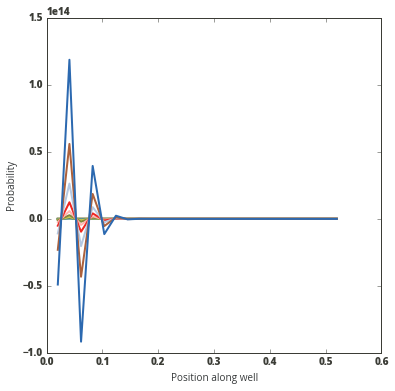

In [135]:
# plot space-time concentration
# figure()
# imshow(sol, aspect='auto')

# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 50
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
# 'alpha_' + str(params['ALPHA']) + '__diff_' + str(params['DCOEFF'])
# savefig('harmonic_alpha_1__a_p2__V_p4.pdf')


# figure()
# total_conc = sum(sol, axis = 0)
# plot(times,total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

## Find effective drag coefficient

In [73]:
## pick parameter values
# alpha less than one
ALPHA = 1.0
DCOEFF = .2
KAPPA = 8e3
# width of overall potential well. smaller this is, the stronger the forcing
POT_DIAM = 1.0
# width of reactive well
WELL_DIAM = .15
params = (ALPHA, DCOEFF, KAPPA, POT_DIAM, WELL_DIAM)

well_diams = linspace(.001,.5,10)

allsol=list()

for diam in well_diams:
    WELL_DIAM = diam
    params = (ALPHA, DCOEFF, KAPPA, POT_DIAM, WELL_DIAM)
    allsol.append( rk4_mesh(y0, nxt_step, 0.0, actual_time, dt, [space, dx, params]) )
    print (diam)

NameError: name 'actual_time' is not defined

NameError: name 'allsol' is not defined

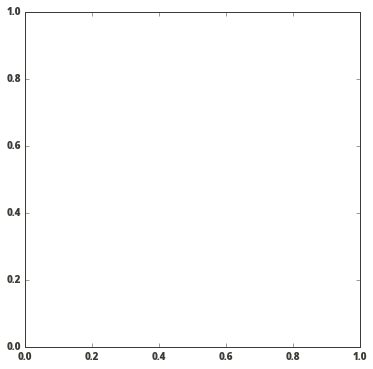

In [41]:
figure()
hold(True)
gg=list()
for sol in allsol:
    total_conc = sum(sol, axis = 0)
    gg.append(1/sum(total_conc[:-1]))
loglog(1/well_diams**2, array(gg),'.',markersize=10)
# loglog(well_diams, array(gg),'.',markersize=10)


### Use LSODA integrator

In [33]:
from scipy.integrate import ode

def nxt_step(timepoint, yvals, settings_and_params):
    settings, params = settings_and_params
    jac = jacob(timepoint, yvals, [settings, params])
    nxt_vals = jac.dot(yvals)
    return nxt_vals

## pick parameter values
params = dict()
# width of reactive well
params['WELL_DIAM'] = .02
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 4e-1
params['DCOEFF'] = 1e-6
# alpha less than one
params['ALPHA']= .5


## set integrator settings
settings = dict()

space_pts = 100
ACTUAL_LENGTH = .5
dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

time_pts = 1e6
start_time = 0.0
stop_time = 17.0
dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times



r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
# r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
# r = ode(nxt_step, jacob).set_integrator('dop853')
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = stop_time
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T

gauss = exp(-space**2/(4*params['POT_DIAM']**2))
gauss = gauss[:, None]
sol = sol*gauss


radpart = 4*pi*(space**2)
radpart = radpart[:, None]
sol = sol*radpart

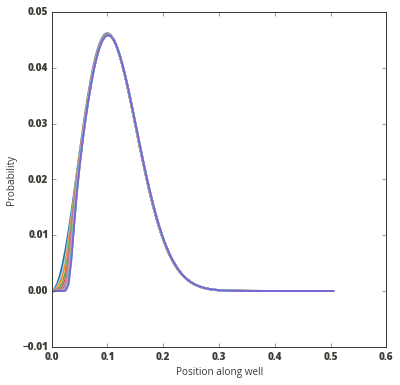

In [34]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# figure()
# figure() 
# total_conc = sum(sol, axis = 0)
# plot(times,total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

In [37]:
## pick parameter values

save_full_sol = False
save_fht = False

well_diams = linspace(.001,.1,40)
well_diams = expspace(.001,.1,40)

allsol = list() # not recommended for more than 10 points

all_fht = list()

all_timesums = list()


for diam in well_diams:
    
    params['POT_DIAM'] = diam
    
    # have to re-intialize because r is a generator
    r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
    r.set_initial_value(y0, times[0])
    r.set_f_params([settings, params])
    r.set_jac_params([settings, params])
    t1 = stop_time
    
    sol = list()
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        sol.append(r.y)
    sol = array(real(sol)).T
    
    gauss = exp(-space**2/(4*params['POT_DIAM']**2))
    gauss = gauss[:, None]
    sol = sol*gauss

    radpart = 4*pi*(space**2)
    radpart = radpart[:, None]
    sol = sol*radpart
    
    # integrate out space
    timesum = sum(sol, axis = 0)
    all_timesums.append( timesum )
    
    
    
    if save_full_sol:
        allsol.append( sol )
    
    if save_fht:
        all_fht.append( -diff(timesum) )
    
    
    print (diam)

0.001
0.0011253355826
0.00126638017347
0.0014251026703
0.00160371874375
0.00180472176683
0.0020309176209
0.00228546386413
0.00257191380906
0.00289426612472
0.00325702065566
0.00366524123708
0.0041246263829
0.00464158883361
0.00522334507427
0.00587801607227
0.00661474064123
0.00744380301325
0.00837677640068
0.00942668455118
0.0106081835514
0.0119377664171
0.013433993326
0.0151177507062
0.0170125427985
0.0191448197617
0.0215443469003
0.0242446201708
0.0272833337649
0.0307029062976
0.0345510729459
0.0388815518031
0.0437547937507
0.0492388263171
0.0554102033001
0.0623550734127
0.070170382867
0.078965228685
0.0888623816274
0.1


In [ ]:
# import pickle
# namestr = 'MANYSOL__alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
# str(params['KAPPA']) + '__reacdiam_'+ str(params['POT_DIAM'])

# thefile = open(namestr + '.pkl', 'w')
# pickle.dump(allsol, thefile)

In [ ]:
# import cPickle as pickle
# allsol = pickle.load(namestr + '.pkl')

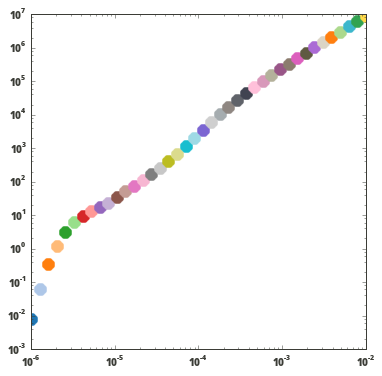

In [32]:
for (xval, timesum) in zip(well_diams**2, all_timesums):
    yval = sum(timesum)
    loglog(xval, yval, '.', markersize=25)
    
# nmstr = 'rough_mfpt_time_versus_well_squared_kappa=4e-1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr, params)



# hold(True)
# loglog(well_diams**2, well_diams**4)
# # loglog(well_diams**2, well_diams**3)

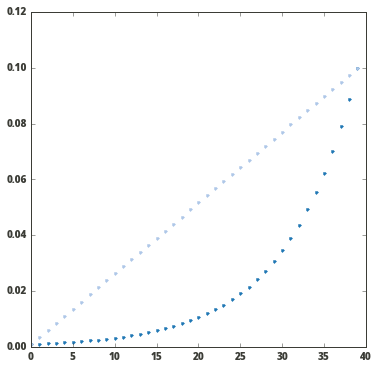

In [29]:
def expspace(lowlim, uplum, npts):
    '''
    logarithmically sample an interval
    '''
    return exp(linspace(log(lowlim), log(uplum),npts))
    
    
plot(expspace(.001, .1,40),'.')
hold(True)
plot(linspace(.001, .1,40),'.')

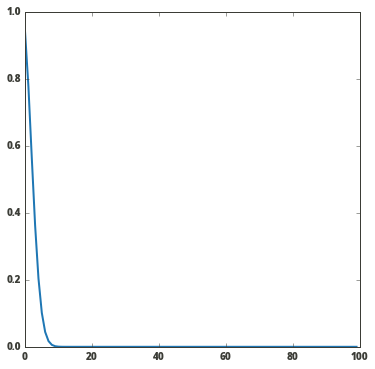

In [26]:
# Check to make sure that size of gaussian is reasonable 
# given the size of the simulation box

gauss = exp(-space**2/(4*(.01)**2))
gauss = gauss[:, None]
plot(gauss)

# Calculate first passage time distribution

In [ ]:
# Make a list of fht if you haven't already

all_fht = list()
for spec_sol in allsol:
    all_fht.append( make_fht(times, spec_sol) )

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


NameError: name 'fht' is not defined

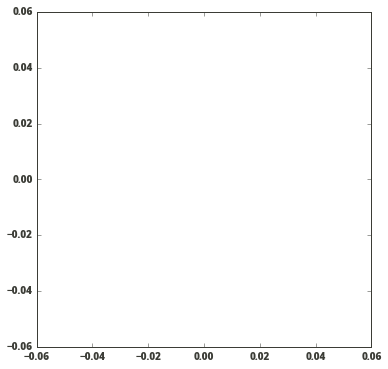

In [22]:
saveflag = False

figure()
hold(True)
all_tau = list()
all_laplace = list()
all_timescales = list()

for timesum in all_timesums:
    
    plot( times[::1000], log(log(timesum[::1000])) )
    
    # complete mean first passage time
    krate = mean( diff(log(timesum)) )
    krate = krate/mean( diff(times) )
    tau = -1/krate
    all_tau.append(tau)
    
    # calculate an approximate laplace transform
    timestep = median(diff(times))
    out = janky_laplace(timesum, num_lvls=200)
    amps = out[1]
    all_timescales.append(timestep/out[0])
    
    # don't take laplace of first-hitting distribution; 
    # take laplace of actual time traces
    
    all_laplace.append( amps[:,::1000].dot( timesum[::1000] )  )
    

if saveflag:
    savefig('xxx_pdeoft_for_various_potdiam.pdf')


# figure()
# hold(True)
# for sq_diam, tau, in zip(well_diams**2, all_tau):
#     loglog(sq_diam,tau,'.',markersize=25)
# if saveflag:
#     savefig('xxmfpt_versus_potdiam.pdf')


# figure()
# hold(True)                      
# for timescale, lapt in zip(all_timescales, all_laplace):
#     loglog(timescale, lapt,'.')
# if saveflag:
#     savefig('all_laplace_pde.pdf')



In [17]:
len(all_timesums)

20

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


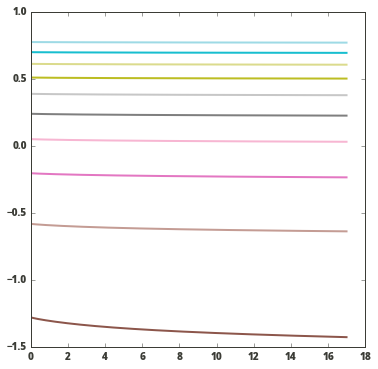

In [15]:
hold(True)
for timesum in all_timesums:
    plot( times[::1000], log(log(timesum[::1000])) )
# ylim([-1,1])

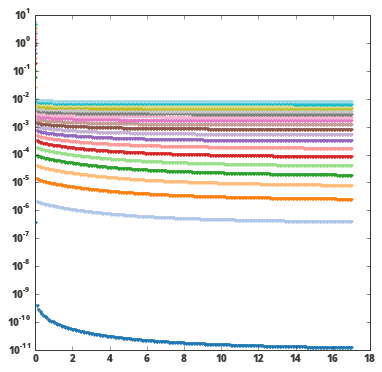

In [91]:
figure()
hold(True)                      
for timescale, lapt in zip(all_timescales, all_laplace):
    semilogy(timescale, lapt,'.')
if saveflag:
    savefig('all_laplace_pde.pdf')

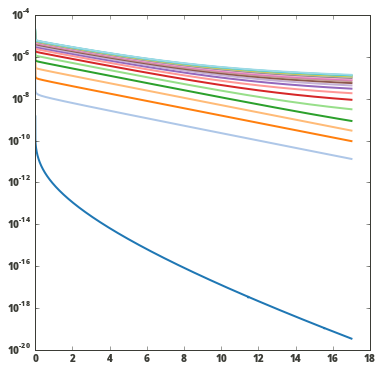

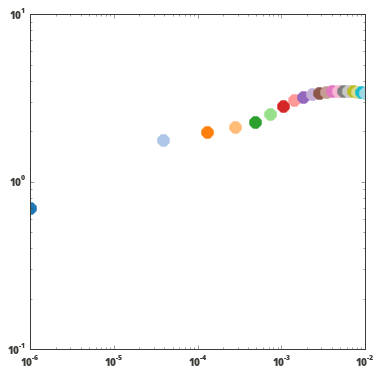

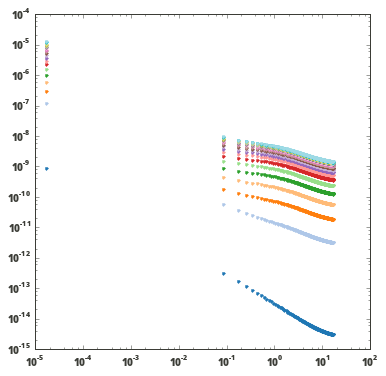

In [77]:
# # sol_time = sum(sol, axis = 0)

# saveflag = True

# figure()
# hold(True)
# all_tau=list()
# all_laplace = list()
# all_timescales = list()
# for fht in all_fht:
    
#     semilogy(times[:-1],fht)
    
#     # complete mean first passage time
#     krate = mean( diff(log(fht)) )
#     krate = krate/mean( diff(times) )
#     tau = -1/krate
#     all_tau.append(tau)
    
#     # calculate an approximate laplace transform
#     timestep = median(diff(times))
#     out = janky_laplace(fht, num_lvls=200)
#     amps = out[1]
#     all_timescales.append(timestep/out[0])
    
#     # don't take laplace of first-hitting distribution; 
#     # take laplace of actual time traces
    
#     all_laplace.append( amps[:,::1000].dot( fht[::1000] )  )
    
    

# if saveflag:
#     savefig('first_hitting_dists_for_various_potdiam.pdf')


# figure()
# hold(True)
# for sq_diam, tau, in zip(well_diams**2, all_tau):
#     loglog(sq_diam,tau,'.',markersize=25)
# if saveflag:
#     savefig('mfpt_versus_potdiam.pdf')


# figure()
# hold(True)                      
# for timescale, lapt in zip(all_timescales, all_laplace):
#     loglog(timescale, lapt,'.')
# if saveflag:
#     savefig('all_laplace_fht.pdf')



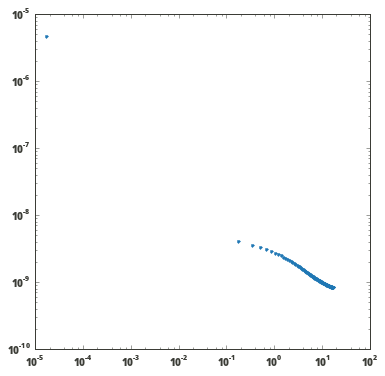

In [179]:
timestep = median(diff(times))

out = janky_laplace(fht, num_lvls=100)
amps = out[1]

timescales = timestep/out[0]

# downsample to plot
loglog(timescales, amps[:,::1000].dot(fht[::1000]),'.')
# savefig('laplace_fht.pdf')

In [21]:
## pick parameter values


def timescale_vs_asquared(well_diams):
    '''
    Estimate the characteristic timescale of the reaction diffusion system 
    as a function of the well diameter. This code does not save the full 
    solution for memory reasons.
    '''
                    

    save_full_sol = False #not recommended for more than 10 points
    save_fht = False

    allsol = list()

    all_fht = list()

    all_timesums = list()


    for diam in well_diams:
        
        params['POT_DIAM'] = diam

        # have to re-intialize because r is a generator expression
        r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
        r.set_initial_value(y0, times[0])
        r.set_f_params([settings, params])
        r.set_jac_params([settings, params])
        t1 = stop_time

        sol = list()
        while r.successful() and r.t < t1:
            r.integrate(r.t+dt)
            sol.append(r.y)
        sol = array(real(sol)).T

        gauss = exp(-space**2/(4*params['POT_DIAM']**2))
        gauss = gauss[:, None]
        sol = sol*gauss

        radpart = 4*pi*(space**2)
        radpart = radpart[:, None]
        sol = sol*radpart

        # integrate out space
        timesum = sum(sol, axis = 0)
        all_timesums.append( timesum )

        if save_full_sol:
            allsol.append( sol )

        if save_fht:
            all_fht.append( -diff(timesum) )


        print (diam)
        
    return array(all_timesums)


def timescale_vs_asquared_vs_kappa(well_diams, kvals):
    
    outs = list()
    
    for kval in kvals:
        params['KAPPA'] = kval
        outs.append( sum(timescale_vs_asquared(well_diams), axis=1) )
        
        
    

# Appendix code

In [ ]:
import unittest

class IntegratorTest(unittest.TestCase):
    def test(self):
        self.assertEqual(fun(3), 4)

In [ ]:
def nxt_step(yvals, timepoint, dt, settings, params):
    
    assert dt > 0
    
    allspace = settings['space']
    dx = allspace[2]-allspace[1]
    
    WELL_DIAM = params['WELL_DIAM']
    POT_DIAM = params['POT_DIAM']
    KAPPA = params['KAPPA']
    DCOEFF = params['DCOEFF']
    ALPHA = params['ALPHA']
    
    DCOEFF = ALPHA *(timepoint**(ALPHA-1))*DCOEFF
    
    # remove this and change allspace
    a = POT_DIAM

    L = len(yvals)
        
    nxt_vals = zeros(len(yvals))
    
    # second derivative step
    lap = lap2d(L) 
    nxt_vals += (1/dx**2)*lap.dot(yvals)
    
    
    # first derivative steps
    drv = grad1D(L)
    drvvals = (1/dx)*drv.dot(yvals)
    nxt_vals += (4*drvvals)/allspace
    nxt_vals += -(3/4)*allspace*drvvals/(a**2)
    
    
    # other steps
    nxt_vals += (1/(8*a**4))*(allspace**2)*yvals
    nxt_vals += -(1/a**2)*yvals
    # assume \ell = 0
    nxt_vals += (2/(allspace**2))*yvals
    
    
    # now multiply by diffusion coefficient and all that
    nxt_vals = -DCOEFF*nxt_vals
    
    # now implement reaction step
    drain_window = double(allspace < WELL_DIAM)
    
    # smooth step
#     drain_window = 1-smoothstep(linspace(0,L,L),center=floor(WELL_DIAM/allspace[-1]),sharpness=.9)
    
    nxt_vals += -KAPPA*drain_window*yvals
    
    # now implement boundary conditions
    nxt_vals[0] = nxt_vals[1]
    nxt_vals[-1] = nxt_vals[-2]
    
    return nxt_vals

In [33]:
well_diams = linspace(.001,.1,20)
kvals = linspace(1e-4,1e-5, 5)
outs = timescale_vs_asquared(well_diams)

0.001
0.00621052631579
0.0114210526316
0.0166315789474
0.0218421052632
0.0270526315789
0.0322631578947
0.0374736842105
0.0426842105263
0.0478947368421
0.0531052631579
0.0583157894737
0.0635263157895
0.0687368421053
0.0739473684211
0.0791578947368
0.0843684210526
0.0895789473684
0.0947894736842
0.1


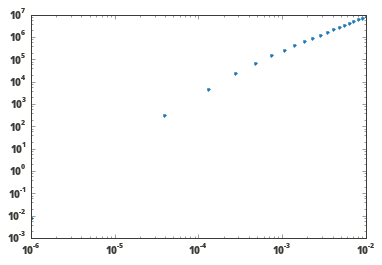

In [36]:
loglog(well_diams**2, sum(array(outs),axis=1),'.')